In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
import networkx as nx
import os
import helper
import random

In [2]:
class GraphDQN(nn.Module): # Input features → GCNConv1 → ReLU → GCNConv2 → ReLU → Linear → Output
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphDQN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return x 

In [3]:
def process_edges_files(dataset_folder):
    graph_list = []
    for filename in os.listdir(dataset_folder):
        if filename.endswith(".edges"):
            # Load each .edges file as a separate graph
            G = nx.read_edgelist(os.path.join(dataset_folder, filename))
            
            # Calculate centrality measures
            degree_centrality = nx.degree_centrality(G)
            betweenness_centrality = nx.betweenness_centrality(G)
            pagerank = nx.pagerank(G)
            
            # Assign target Q-values to nodes
            for node in G.nodes:
                q_value = (
                    0.4 * degree_centrality[node]
                    + 0.3 * betweenness_centrality[node]
                    + 0.3 * pagerank[node]
                )
                G.nodes[node]['target_q_value'] = q_value
            
            graph_list.append(G)
    return graph_list

In [4]:
def convert_nx_to_torch_geo(nx_graph):
    for node in nx_graph.nodes():
        if 'feature' not in nx_graph.nodes[node]:
            nx_graph.nodes[node]['feature'] = torch.rand(10) 
    
    data = from_networkx(nx_graph)
    data.x = torch.stack([data.feature[i] for i in range(len(data.feature))])
    return data

In [5]:
def convert_graphs_to_torch_geo(graph_list):
    torch_geo_data = []
    for G in graph_list:
        # Use existing conversion function
        data = convert_nx_to_torch_geo(G)
        
        # Assign target Q-values as labels in the PyTorch Geometric Data format
        target_q_values = [G.nodes[node]['target_q_value'] for node in G.nodes]
        data.y = torch.tensor(target_q_values, dtype=torch.float)
        
        torch_geo_data.append(data)
    return torch_geo_data

In [6]:
# def train_dqn(model, graph_list, optimizer, criterion, num_episodes):
#     for episode in range(num_episodes):
#         for graph in graph_list:
#             graph_data = convert_nx_to_torch_geo(graph)
#             node_features = graph_data.x
#             edge_index = graph_data.edge_index
            
#             q_values = model(node_features, edge_index)

#             target_q_values = torch.rand(q_values.size())

#             loss = criterion(q_values, target_q_values)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

In [7]:
def train_dqn(model, data_list, num_epochs=100, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        total_loss = 0
        
        for data in data_list:
            optimizer.zero_grad()
            
            # Forward pass
            out = model(data.x, data.edge_index)
            
            # Compute loss with actual target Q-values
            loss = F.mse_loss(out, data.y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(data_list):.4f}")


In [8]:
# def get_most_influential_nodes(model, nx_graph, top_k=5):
#     model.eval()  
#     graph_data = convert_nx_to_torch_geo(nx_graph)
    
#     with torch.no_grad():
#         node_features = graph_data.x
#         edge_index = graph_data.edge_index

#         q_values = model(node_features, edge_index)

#     _, top_nodes = torch.topk(q_values.squeeze(), k=top_k)
    
#     return top_nodes.tolist()

In [9]:
def get_most_influential_nodes(model, nx_graph, top_k=5):
    model.eval() 
    graph_data = convert_nx_to_torch_geo(nx_graph)
    
    with torch.no_grad():
        node_features = graph_data.x
        edge_index = graph_data.edge_index
        
   
        q_values = model(node_features, edge_index)
    
    with torch.no_grad():
        node_features = graph_data.x
        edge_index = graph_data.edge_index
        
   
        q_values = model(node_features, edge_index)
    
    _, top_indices = torch.topk(q_values.squeeze(), k=top_k)

    node_mapping = list(nx_graph.nodes) 
    top_nodes = [node_mapping[i] for i in top_indices.tolist()]

    return top_nodes
    
    _, top_indices = torch.topk(q_values.squeeze(), k=top_k)

    node_mapping = list(nx_graph.nodes) 
    top_nodes = [node_mapping[i] for i in top_indices.tolist()]

    return top_nodes

In [10]:
files = os.listdir("dataset")

edges = []
for i in files:
    if i.endswith(".edges"):
        edges.append(i)

graph_list = []

for i in edges:
    graph = helper.read_graph(f"dataset/{i}")
    circle_filename = i.split(".")[0]
    colored_graph = helper.assign_colors_to_nodes(graph, f'dataset/{circle_filename}.circles')
    graph_list.append(colored_graph)


In [11]:
len(graph_list)

10

In [12]:
# graph1 = nx.karate_club_graph()
# graph2 = nx.erdos_renyi_graph(34, 0.05)

# graph_list = [graph1, graph2]

In [13]:
input_dim = 10 
hidden_dim = 32
output_dim = 1


In [14]:
model = GraphDQN(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [15]:
graph_list = process_edges_files("dataset")
torch_geo_data = convert_graphs_to_torch_geo(graph_list)

In [16]:
train_dqn(model, torch_geo_data)

C:\Users\rjaga\AppData\Local\Temp\ipykernel_13096\4186082623.py:14: UserWarning: Using a target size (torch.Size([333])) that is different to the input size (torch.Size([333, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, data.y)
C:\Users\rjaga\AppData\Local\Temp\ipykernel_13096\4186082623.py:14: UserWarning: Using a target size (torch.Size([1034])) that is different to the input size (torch.Size([1034, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, data.y)
C:\Users\rjaga\AppData\Local\Temp\ipykernel_13096\4186082623.py:14: UserWarning: Using a target size (torch.Size([786])) that is different to the input size (torch.Size([786, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, data.y)
C:\Users\rjaga\AppData\Local\Temp\ipykernel_130

Epoch 1/100, Loss: 0.0052
Epoch 2/100, Loss: 0.0034
Epoch 3/100, Loss: 0.0023
Epoch 4/100, Loss: 0.0018
Epoch 5/100, Loss: 0.0018
Epoch 6/100, Loss: 0.0019
Epoch 7/100, Loss: 0.0018
Epoch 8/100, Loss: 0.0017
Epoch 9/100, Loss: 0.0018
Epoch 10/100, Loss: 0.0017
Epoch 11/100, Loss: 0.0017
Epoch 12/100, Loss: 0.0017
Epoch 13/100, Loss: 0.0017
Epoch 14/100, Loss: 0.0017
Epoch 15/100, Loss: 0.0017
Epoch 16/100, Loss: 0.0017
Epoch 17/100, Loss: 0.0017
Epoch 18/100, Loss: 0.0016
Epoch 19/100, Loss: 0.0016
Epoch 20/100, Loss: 0.0016
Epoch 21/100, Loss: 0.0016
Epoch 22/100, Loss: 0.0016
Epoch 23/100, Loss: 0.0016
Epoch 24/100, Loss: 0.0016
Epoch 25/100, Loss: 0.0016
Epoch 26/100, Loss: 0.0016
Epoch 27/100, Loss: 0.0016
Epoch 28/100, Loss: 0.0016
Epoch 29/100, Loss: 0.0016
Epoch 30/100, Loss: 0.0016
Epoch 31/100, Loss: 0.0016
Epoch 32/100, Loss: 0.0016
Epoch 33/100, Loss: 0.0016
Epoch 34/100, Loss: 0.0016
Epoch 35/100, Loss: 0.0016
Epoch 36/100, Loss: 0.0016
Epoch 37/100, Loss: 0.0016
Epoch 38/1

In [17]:
# num_episodes = 100
# train_dqn(model, graph_list, optimizer, criterion, num_episodes)

## Saving model

In [18]:
torch.save(model.state_dict(), 'graph_dqn_model.pth')

---

---

## Testing with a new graph

In [19]:
graphname = "12831.edges"
test_graph = helper.read_graph(graphname)
circle_filename = graphname.split(".")[0]
test_graph_color = helper.assign_colors_to_nodes(test_graph, f'{circle_filename}.circles')

In [20]:
test_graph_color

In [21]:
# test_graph = nx.karate_club_graph() 
top_nodes = get_most_influential_nodes(model, test_graph_color, top_k=5)
print("Top 5 Influential Nodes:", top_nodes)

Top 5 Influential Nodes: [98065221, 12081222, 91443374, 19507576, 1859981]


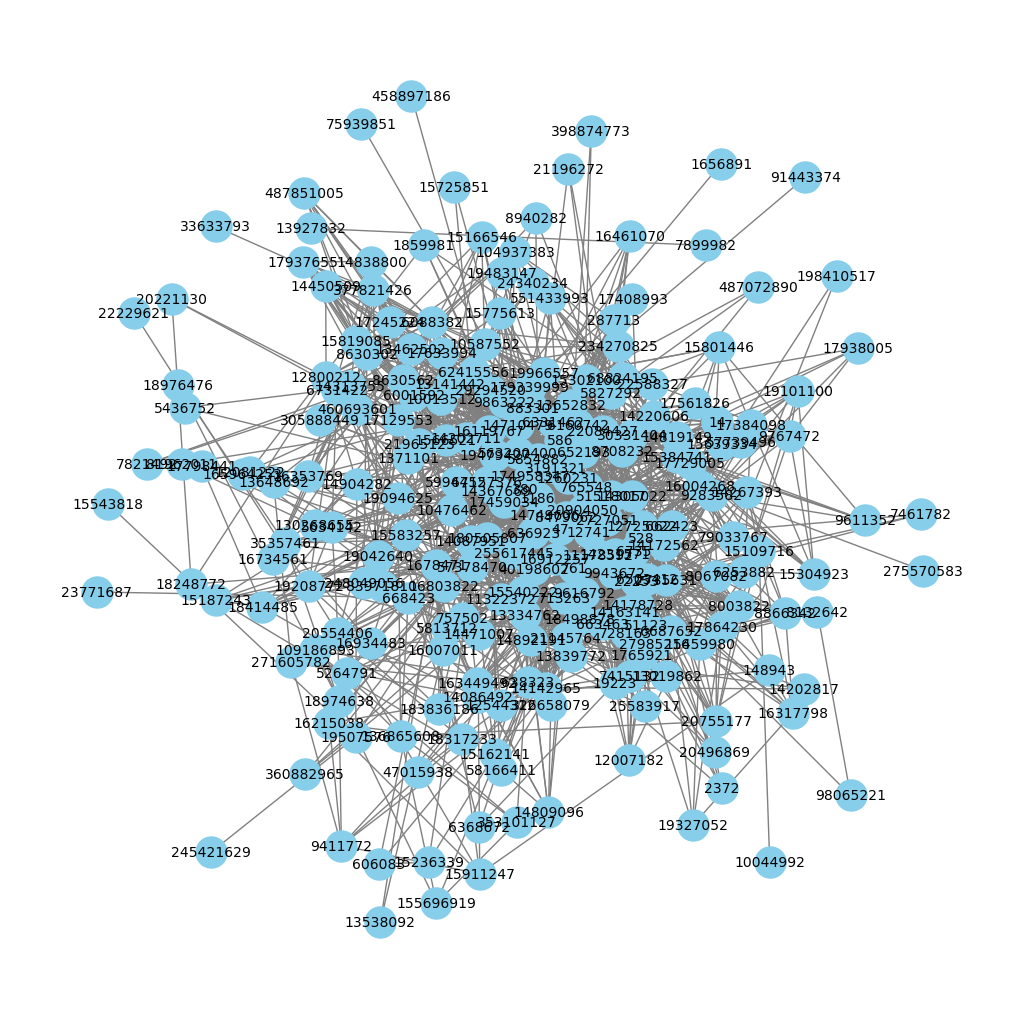

In [22]:
helper.display_graph(test_graph)

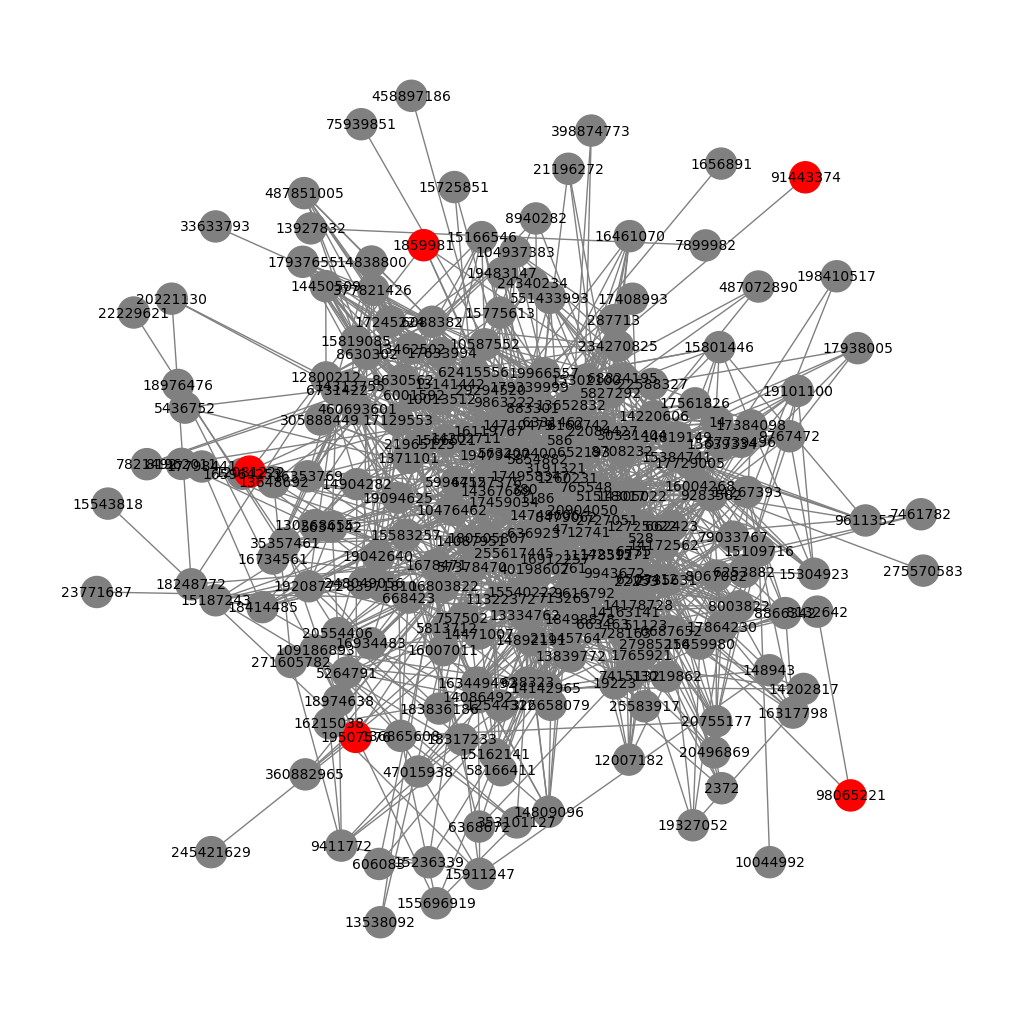

In [23]:
outputGraph = helper.color_specific_nodes_red(test_graph, top_nodes)
helper.display_colored_graph(outputGraph)

In [24]:
# coloured_graph = helper.color_specific_nodes_red(test_graph, top_nodes)
# helper.display_colored_graph(colored_graph)

---

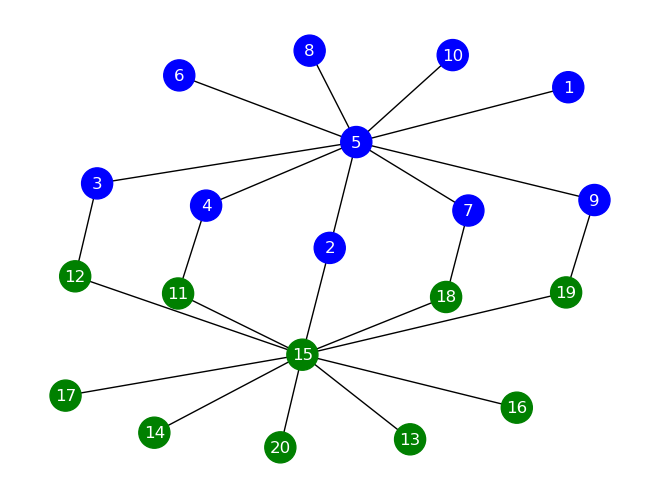

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add nodes 1 to 20
G.add_nodes_from(range(1, 21))

# Add edges for node 5
edges_5 = [(5, i) for i in [1, 2, 3, 4, 6, 7, 8, 9, 10]]
G.add_edges_from(edges_5)

# Add edges for node 15
edges_15 = [(15, i) for i in [11, 12, 13, 14, 16, 17, 18, 19, 20]]
G.add_edges_from(edges_15)

# Add some connections between the two sub-networks
cross_edges = [(3, 12), (7, 18), (2, 15), (9, 19), (4, 11)]  # Sample cross-connections
G.add_edges_from(cross_edges)

# Color nodes: first 10 nodes blue, next 10 nodes green
node_colors = ['blue' if node <= 10 else 'green' for node in G.nodes]

# Draw the graph with color
pos = nx.spring_layout(G)  # Positioning the nodes
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_color='white')

# Show the graph
plt.show()


Top 5 Influential Nodes: [12, 7]


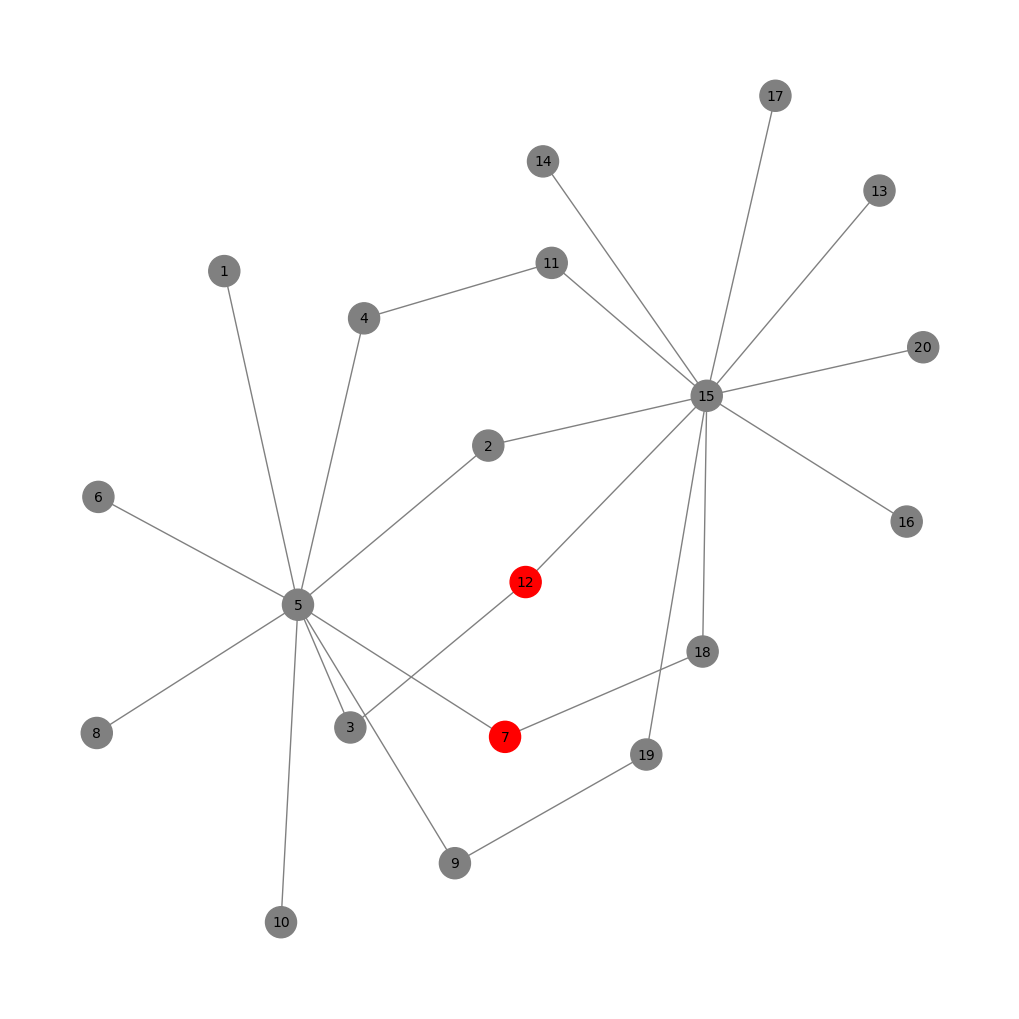

In [26]:
test_graph = G  # This is the graph created above

top_nodes = get_most_influential_nodes(model, test_graph, top_k=2)
print("Top 5 Influential Nodes:", top_nodes)

outputGraph = helper.color_specific_nodes_red(test_graph, top_nodes)
helper.display_colored_graph(outputGraph)


---

For accuracy measure refer the https://chatgpt.com/share/6730c9ee-7d58-8008-aa49-306c925277c0

Need some correction